<a href="https://colab.research.google.com/github/GinuraAdikari/InsightHive/blob/Sentiment_Analysis/model_ABSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mount Google drive & Load ATE**

In [19]:
import os
import pandas as pd
import numpy as np
import string
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from transformers import BertPreTrainedModel, BertModel, BertConfig

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# ========== 1. Load Preprocessed Dataset ==========

absa_file = "ABSA_dataset.csv"
absa_df = pd.read_csv(absa_file)
print(f"Loaded dataset with {len(absa_df)} rows.")

Loaded dataset with 1310 rows.


In [3]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# ========== 2. Load ATE Model ==========

ate_model_path = "/content/drive/MyDrive/ABSA/roberta_ate_model"
ate_tokenizer_path = "/content/drive/MyDrive/ABSA/roberta_tokenizer"

ate_model = AutoModelForTokenClassification.from_pretrained(ate_model_path)
ate_tokenizer = AutoTokenizer.from_pretrained(ate_tokenizer_path, add_prefix_space=True)
ate_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ate_model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

## **Extract Aspect using ATE**

In [5]:
# ========== 3. Aspect Extraction ==========
def extract_aspects(text):
    tokens = ate_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = ate_model(**tokens).logits
    predictions = torch.argmax(outputs, dim=2).squeeze().tolist()
    tokens_list = ate_tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze())

    aspect_terms = []
    current_aspect = []
    for token, label in zip(tokens_list, predictions):
        if token in string.punctuation:
            continue
        if label == 1:  # B-ASP
            if current_aspect:
                aspect_terms.append(" ".join(current_aspect))
                current_aspect = []
            current_aspect.append(token.replace("Ġ", ""))
        elif label == 2 and current_aspect:  # I-ASP
            current_aspect.append(token.replace("Ġ", ""))
        else:
            if current_aspect:
                aspect_terms.append(" ".join(current_aspect))
                current_aspect = []
    if current_aspect:
        aspect_terms.append(" ".join(current_aspect))

    return aspect_terms


In [6]:
# === Apply Aspect Extraction ===
absa_df["Aspects"] = absa_df["Cleaned_review"].apply(extract_aspects)
print(absa_df[["Cleaned_review", "Aspects"]].head())

                                      Cleaned_review  \
0  one best game music soundtrack game didnt real...   
1  best purchase ever bought exersaucer little gu...   
2  book slow weak one beststhank god slow weak bo...   
3  mustread every southern lady failed love book ...   
4  horrible watch napoleon want funny movie suck ...   

                                             Aspects  
0  [one best game music soundtrack game, fact, sm...  
1  [<s>, best purchase, ex ers au cer little guy,...  
2  [<s>, book, usual frightening detailed book st...  
3  [every southern lady failed love book book che...  
4  [<s>, horrible watch nap oleon, funny movie su...  


## **Create ABSC Training Data**

In [7]:
# ========== 4. Clean Aspects ==========

# Define stopwords
stopwords = set(stopwords.words('english'))

def clean_aspects(aspects):
    cleaned_aspects = []
    for aspect in aspects:
        # Remove special tokens
        if aspect in ["<s>", "</s>"]:
            continue
        # Remove punctuation and split into words
        words = [word.strip(string.punctuation) for word in aspect.split()]
        # Remove stopwords and empty strings
        words = [word for word in words if word.lower() not in stopwords and word]
        if words:
            cleaned_aspects.append(" ".join(words))
    return cleaned_aspects

absa_df["Cleaned_Aspects"] = absa_df["Aspects"].apply(clean_aspects)
print(absa_df[["Cleaned_review", "Cleaned_Aspects"]].head())

                                      Cleaned_review  \
0  one best game music soundtrack game didnt real...   
1  best purchase ever bought exersaucer little gu...   
2  book slow weak one beststhank god slow weak bo...   
3  mustread every southern lady failed love book ...   
4  horrible watch napoleon want funny movie suck ...   

                                     Cleaned_Aspects  
0  [one best game music soundtrack game, fact, sm...  
1  [best purchase, ex ers au cer little guy, musi...  
2         [book, usual frightening detailed book st]  
3  [every southern lady failed love book book che...  
4  [horrible watch nap oleon, funny movie suck mo...  


In [8]:
# ========== 5. Create ABSC Dataset ==========

sia = SentimentIntensityAnalyzer()

def get_aspect_context_sentiment(review, aspect, window=30):
    idx = review.lower().find(aspect.lower())
    if idx == -1:
        return 2  # Neutral or unknown

    start = max(0, idx - window)
    end = min(len(review), idx + len(aspect) + window)
    context = review[start:end]

    score = sia.polarity_scores(context)["compound"]
    if score > 0.05:
        return 1  # Positive
    elif score < -0.05:
        return 0  # Negative
    else:
        return 2  # Neutral (optional to include)

In [9]:
# === Create Aspect-Review-Sentiment Triplets ===
absc_data = []
for _, row in absa_df.iterrows():
    review = row["Cleaned_review"]
    for aspect in row["Cleaned_Aspects"]:
        sentiment = get_aspect_context_sentiment(review, aspect)
        if sentiment in [0, 1]:  # Keep binary labels only
            absc_data.append({
                "Review": review,
                "Aspect": aspect,
                "Sentiment": sentiment
            })

absc_df = pd.DataFrame(absc_data)
absc_df["Sentiment"] = absc_df["Sentiment"].astype(int)

In [10]:
# Preview
print("\nSample data:")
print(absc_df.head())
print(f"\nTotal samples: {len(absc_df)}")
print("\nClass distribution:\n", absc_df["Sentiment"].value_counts())


Sample data:
                                              Review  \
0  one best game music soundtrack game didnt real...   
1  one best game music soundtrack game didnt real...   
2  one best game music soundtrack game didnt real...   
3  one best game music soundtrack game didnt real...   
4  one best game music soundtrack game didnt real...   

                                Aspect  Sentiment  
0  one best game music soundtrack game          1  
1                                 fact          0  
2             small portion game music          1  
3                     connection chron          1  
4   great well led purchase soundtrack          1  

Total samples: 5872

Class distribution:
 Sentiment
1    4275
0    1597
Name: count, dtype: int64


## **Tokenize & Build Dataset**

In [11]:
# ========== 6. Tokenization ==========

absc_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenized = absc_tokenizer(
    absc_df["Review"].tolist(),
    absc_df["Aspect"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=128
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens a

In [12]:
print("Total samples:", len(absc_df))
print("Class distribution:\n", absc_df["Sentiment"].value_counts())
print("Sample tokens:\n", absc_tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0]))

Total samples: 5872
Class distribution:
 Sentiment
1    4275
0    1597
Name: count, dtype: int64
Sample tokens:
 ['[CLS]', 'one', 'best', 'game', 'music', 'soundtrack', 'game', 'didn', '##t', 'really', 'play', 'despite', 'fact', 'played', 'small', 'portion', 'game', 'music', 'heard', 'plus', 'connection', 'ch', '##ron', '##o', 'trigger', 'great', 'well', 'led', 'purchase', 'soundtrack', 'remains', 'one', 'favorite', 'album', 'incredible', 'mix', 'fun', 'epic', 'emotional', 'song', 'sad', 'beautiful', 'track', 'especially', 'like', 'there', 'many', 'kind', 'song', 'video', 'game', 'soundtrack', 'must', 'admit', 'one', 'song', 'life', '##a', 'distant', 'promise', 'brought', 'tear', 'eye', 'many', 'occasions', '##my', 'one', 'complaint', 'soundtrack', 'use', 'guitar', 'fr', '##etti', '##ng', 'effect', 'many', 'song', 'find', 'distracting', 'even', 'weren', '##t', 'included', 'would', 'still', 'consider', 'collection', 'worth', '[SEP]', 'one', 'best', 'game', 'music', 'soundtrack', 'game',

In [13]:
# === ABSC Pre-Training Validation ===

print("\n===== ABSC Dataset Validation =====")

# 1. Check for missing values
missing = absc_df.isnull().sum()
print("\nMissing values:\n", missing)

# 2. Class distribution
print("\nClass distribution:\n", absc_df["Sentiment"].value_counts())

# 3. Unique sentiment labels
print("\nUnique Sentiment Labels:", absc_df["Sentiment"].unique())

# 4. Sample review-aspect-sentiment
print("\nRandom Samples:")
print(absc_df[["Review", "Aspect", "Sentiment"]].sample(5))

# 5. Check if any aspect is not in review
print("\nChecking if aspects are found in reviews...")
aspect_not_found = absc_df[~absc_df.apply(lambda row: row["Aspect"].lower() in row["Review"].lower(), axis=1)]
print(f"Aspects not found in review: {len(aspect_not_found)}")

# 6. Tokenization stats
tokenized = absc_tokenizer(
    absc_df["Review"].tolist(),
    absc_df["Aspect"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=128
)
print("\nMax token length per sample:", tokenized['input_ids'].shape[1])

# 7. Dataset size
print(f"\nTotal training samples: {len(absc_df)}")

print("\n✅ Validation complete. Safe to begin training.")


===== ABSC Dataset Validation =====

Missing values:
 Review       0
Aspect       0
Sentiment    0
dtype: int64

Class distribution:
 Sentiment
1    4275
0    1597
Name: count, dtype: int64

Unique Sentiment Labels: [1 0]

Random Samples:
                                                 Review  \
2172  ultimate quotworstquot mac book nothing repeti...   
5606  always cisco networking need whether router ni...   
258   aint gangsta bch beat crime mob give break kin...   
2441  remember watching cartoon kid wimp ton nightma...   
798   long coming im big fan dr bluesteins work diss...   

                            Aspect  Sentiment  
2172                         money          1  
5606  personally hand issue router          1  
258                         people          0  
2441             book excited read          1  
798                       solution          1  

Checking if aspects are found in reviews...
Aspects not found in review: 0


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Max token length per sample: 128

Total training samples: 5872

✅ Validation complete. Safe to begin training.


## **Train & Save**

In [14]:
# ========== 7. Dataset Class ==========

class ABSADataset(Dataset):
    def __init__(self, texts, aspects, labels, tokenizer):
        self.encodings = tokenizer(texts, aspects, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
# === Data Split ===
train_texts, temp_texts, train_aspects, temp_aspects, train_labels, temp_labels = train_test_split(
    absc_df["Review"].tolist(), absc_df["Aspect"].tolist(), absc_df["Sentiment"].tolist(),
    test_size=0.2, stratify=absc_df["Sentiment"]
)
val_texts, test_texts, val_aspects, test_aspects, val_labels, test_labels = train_test_split(
    temp_texts, temp_aspects, temp_labels, test_size=0.5, stratify=temp_labels
)

train_dataset = ABSADataset(train_texts, train_aspects, train_labels, absc_tokenizer)
val_dataset = ABSADataset(val_texts, val_aspects, val_labels, absc_tokenizer)
test_dataset = ABSADataset(test_texts, test_aspects, test_labels, absc_tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [20]:
# ========== 8. Class Weights ==========
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# ========== 9. Model ==========
class CustomBERTClassifier(BertPreTrainedModel):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(config.hidden_size, 2)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)
        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# === Load model ===
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
model = CustomBERTClassifier.from_pretrained("bert-base-uncased", config=config, class_weights=weights_tensor)

# ========== 10. Metrics ==========
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
        "roc_auc": roc_auc_score(labels, preds),
        "confusion_matrix": confusion_matrix(labels, preds).tolist()
    }

Some weights of CustomBERTClassifier were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# ========== 11. Training Arguments ==========
training_args = TrainingArguments(
    output_dir="./absc_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    logging_dir="./logs"
)

# ========== 12. Trainer ==========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=absc_tokenizer,
    compute_metrics=compute_metrics
)

# ========== 13. Train ==========
trainer.train()

# ========== 14. Save ==========
model.save_pretrained("bert_absc_model")
absc_tokenizer.save_pretrained("bert_absc_tokenizer")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-1c79a091e114>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Confusion Matrix
1,0.697300,0.643040,0.729131,0.788793,0.857143,0.821549,0.622321,"[[62, 98], [61, 366]]"
2,0.696000,0.697421,0.725724,0.734982,0.974239,0.837865,0.518369,"[[10, 150], [11, 416]]"
3,0.648300,0.630673,0.718910,0.792411,0.831382,0.811429,0.625066,"[[67, 93], [72, 355]]"


('bert_absc_tokenizer/tokenizer_config.json',
 'bert_absc_tokenizer/special_tokens_map.json',
 'bert_absc_tokenizer/vocab.txt',
 'bert_absc_tokenizer/added_tokens.json')

In [22]:
from google.colab import files

# Zip and download ATE model
!zip -r bert_absc_model.zip bert_absc_model
files.download("bert_absc_model.zip")

# Zip and download tokenizer
!zip -r bert_absc_tokenizer.zip bert_absc_tokenizer
files.download("bert_absc_tokenizer.zip")

  adding: bert_absc_model/ (stored 0%)
  adding: bert_absc_model/config.json (deflated 48%)
  adding: bert_absc_model/model.safetensors (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: bert_absc_tokenizer/ (stored 0%)
  adding: bert_absc_tokenizer/special_tokens_map.json (deflated 42%)
  adding: bert_absc_tokenizer/vocab.txt (deflated 53%)
  adding: bert_absc_tokenizer/tokenizer_config.json (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Run prediction on test set
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_pred = y_probs.argmax(axis=1)

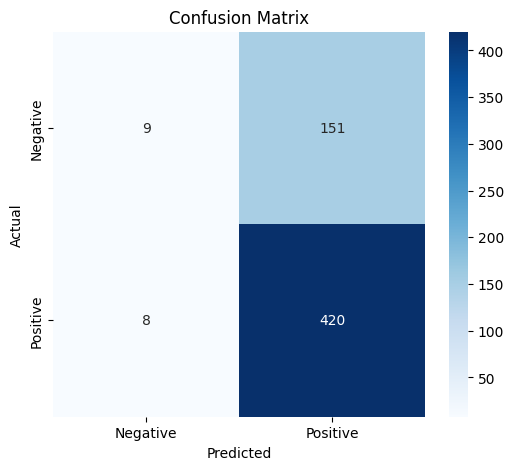

In [24]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

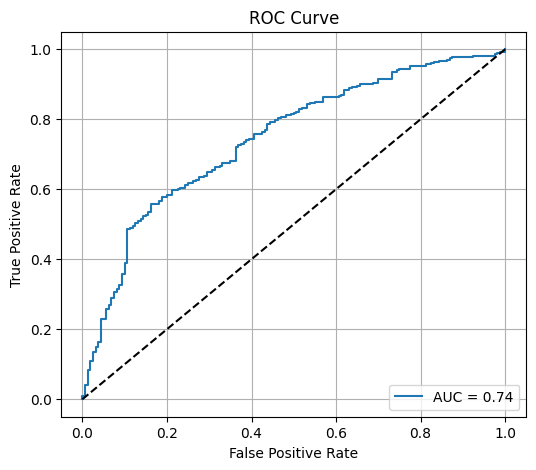

In [25]:
fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

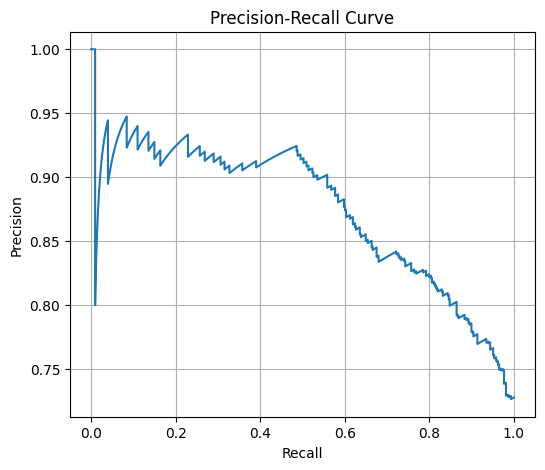

In [26]:
precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()